In [209]:
#Import all dependencies
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl

import hvplot.pandas
from sklearn.cluster import KMeans
import joblib

import matplotlib.pyplot as plt
import numpy as np

# Cleaning

The following cleaning steps are outlined in our [README](README.md) file.

## Phase 1: Reading in Files and Correcting Data Types

In [210]:
#Read in our movie data
movies = pd.read_csv(r"Resources\movies.csv")
movies.head()


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [211]:
#The following code will create columns for each genre which specify whether each movie is in that genre or not
#Create a dictionary to store our genres
genres = {}


In [212]:
#Split the genre column from the movie data into lists and store in a dictionary
for index, row in movies.iterrows():
    genres[row["movieId"]] = row["genres"].split("|")

In [213]:
#Create our list of genres for our genre dictionary
genre_list = ["Action",
"Adventure",
"Animation",
"Children's",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western",
"(no genres listed)"]

In [214]:
#Create a list that will store each genre column
my_list = []

In [215]:
#Fill all of the genre columns with 1 for "yes" or 0 for "no"
for genre in genre_list:
    my_list = []
    for index in movies.index:
        movie = movies["movieId"][index]
        if genre in genres[movie]:
            my_list.append(1)
        else:
            my_list.append(0)
    movies[genre] = my_list

In [216]:
#Clean up the movies DataFrame
movies = movies.drop(columns = ["genres", "title"])
movies.head()

movieId  Action  Adventure  Animation  Children's  Comedy  Crime  \
0        1       0          1          1           0       1      0   
1        2       0          1          0           0       0      0   
2        3       0          0          0           0       1      0   
3        4       0          0          0           0       1      0   
4        5       0          0          0           0       1      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  \
0            0      0        1          0       0        0        0        0   
1            0      0        1          0       0        0        0        0   
2            0      0        0          0       0        0        0        1   
3            0      1        0          0       0        0        0        1   
4            0      0        0          0       0        0        0        0   

   Sci-Fi  Thriller  War  Western  (no genres listed)  
0       0         0    0        0                   0  
1       0         0    0        0                   0  
2       0         0    0        0                   0  
3       0         0    0        0                   0  
4       0         0    0        0                   0

In [217]:
#The following csv is not used in the current iteration of our model, but could be used to increase its complexity
#Read in tag movie metadata
tag_names = pd.read_csv(r"Resources/genome-tags.csv")
tag_list = tag_names["tagId"]
tag_scores = pd.read_csv(r"Resources\genome-scores.csv")
tag_scores.head()

movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075

In [218]:
#Add tag data to the movie data through merge, thereby assigning tag_scores to their movies
merged_df = pd.merge(movies,tag_scores, on = ["movieId"], how = "left")

In [219]:
#Invert rows and columns so that tags are columns, preserving only movieId, tagId, and relevance
pivot_df = merged_df.pivot(index = "movieId", columns = "tagId", values = "relevance")

In [220]:
#Put this inverted data into the movie DataFrame
movies_with_tags = pd.merge(movies, pivot_df, left_on = "movieId", right_index = True, how = "left")

In [221]:
#Drop fully null columns
movies_with_tags = movies_with_tags.dropna(axis=1,how = 'all')
movies_with_tags.head()

movieId  Action  Adventure  Animation  Children's  Comedy  Crime  \
0        1       0          1          1           0       1      0   
1        2       0          1          0           0       0      0   
2        3       0          0          0           0       1      0   
3        4       0          0          0           0       1      0   
4        5       0          0          0           0       1      0   

   Documentary  Drama  Fantasy  ...   1119.0   1120.0   1121.0   1122.0  \
0            0      0        1  ...  0.04050  0.01425  0.03050  0.03500   
1            0      0        1  ...  0.05250  0.01575  0.01250  0.02000   
2            0      0        0  ...  0.06275  0.01950  0.02225  0.02300   
3            0      1        0  ...  0.05325  0.02800  0.01675  0.03875   
4            0      0        0  ...  0.05350  0.02050  0.01425  0.02550   

    1123.0   1124.0   1125.0   1126.0   1127.0   1128.0  
0  0.14125  0.05775  0.03900  0.02975  0.08475  0.02200  
1  0.12225  0.03275  0.02100  0.01100  0.10525  0.01975  
2  0.12200  0.03475  0.01700  0.01800  0.09100  0.01775  
3  0.18200  0.07050  0.01625  0.01425  0.08850  0.01500  
4  0.19225  0.02675  0.01625  0.01300  0.08700  0.01600  

[5 rows x 1148 columns]

In [222]:
#Save the movies_with_tags DataFrame to csv for future use
movies_with_tags.to_csv(r"Resources\movies_with_tags.csv")

## Preparation for Model: (Cleaning: Phase 2)

These steps involve merging our DataFrames so that they are prepared for the model. Our final DataFrame for the model includes data, grouped by user, for average rating by genre and weighted data that accounts for the percentage of a user's ratings which apply to each genre. 

In [223]:
#Read in customer rating data
ratings = pd.read_csv(r"Resources\ratings.csv")
ratings.head()

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

In [224]:
#Join movie and ratings data so that each rating is paired with the movie metadata
ratings = ratings.join(movies.set_index("movieId"), on = "movieId", how = "left")
ratings = ratings.drop(columns=["Children's"])
ratings.head()

userId  movieId  rating   timestamp  Action  Adventure  Animation  Comedy  \
0       1      296     5.0  1147880044       0          0          0       1   
1       1      306     3.5  1147868817       0          0          0       0   
2       1      307     5.0  1147868828       0          0          0       0   
3       1      665     5.0  1147878820       0          0          0       1   
4       1      899     3.5  1147868510       0          0          0       1   

   Crime  Documentary  ...  Film-Noir  Horror  Musical  Mystery  Romance  \
0      1            0  ...          0       0        0        0        0   
1      0            0  ...          0       0        0        0        0   
2      0            0  ...          0       0        0        0        0   
3      0            0  ...          0       0        0        0        0   
4      0            0  ...          0       0        1        0        1   

   Sci-Fi  Thriller  War  Western  (no genres listed)  
0       0         1    0        0                   0  
1       0         0    0        0                   0  
2       0         0    0        0                   0  
3       0         0    1        0                   0  
4       0         0    0        0                   0  

[5 rows x 22 columns]

In [225]:
#Replace zeroes in the ratings DataFrame with null values so that they will not affect our aggregate calculations
genre_columns = ['Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']

for genre in genre_columns:
    ratings[genre] = ratings[genre]*ratings["rating"]
    ratings[genre] = ratings[genre].replace(0,float('nan'))

In [226]:
#Create a DataFrame that contains users' average ratings by genre
weighted_ratings = ratings.groupby("userId").mean().drop(columns=["movieId", "timestamp"])
weighted_ratings = weighted_ratings.fillna(0)

#Save this DataFrame for later reference
average_ratings = weighted_ratings.copy()
weighted_ratings.head()

rating    Action  Adventure  Animation    Comedy     Crime  \
userId                                                                 
1       3.814286  4.125000   3.727273   4.000000  3.869565  4.062500   
2       3.630435  3.696970   3.906667   3.617647  3.317460  3.138889   
3       3.697409  3.640719   3.689394   3.980000  3.454545  3.886364   
4       3.378099  3.186207   3.074561   3.467742  3.611111  3.972973   
5       3.752475  3.722222   3.857143   3.750000  3.571429  4.142857   

        Documentary     Drama   Fantasy  Film-Noir    Horror   Musical  \
userId                                                                   
1          2.000000  3.867925  3.600000        3.5  3.500000  3.700000   
2          0.000000  3.571429  3.982759        0.0  4.000000  3.272727   
3          3.166667  3.890086  3.737179        4.3  3.544444  3.583333   
4          4.100000  3.744898  2.833333        0.0  3.150000  3.642857   
5          0.000000  3.822222  3.500000        0.0  4.666667  3.714286   

         Mystery   Romance    Sci-Fi  Thriller       War   Western  \
userId                                                               
1       3.500000  4.166667  3.700000  4.300000  3.900000  2.500000   
2       3.687500  3.161765  4.017857  3.833333  3.433333  2.500000   
3       3.891667  3.533333  3.696429  3.692469  3.692308  3.750000   
4       3.805556  3.450000  3.164706  3.544643  3.333333  2.833333   
5       4.714286  3.550000  4.090909  4.000000  4.500000  3.000000   

        (no genres listed)  
userId                      
1                      0.0  
2                      0.0  
3                      3.5  
4                      0.0  
5                      0.0

In [227]:
#A user's average rating will skew their relation to other users' interests: if two users rate on different parts of the scale but in the same proportions, we want
#to consider them as in the same cluster. Thus, we turn each rating average into z-scores rather than leaving it on the scale 1-5
for genre in genre_columns:
    weighted_ratings[genre]= (weighted_ratings[genre]-weighted_ratings["rating"])/weighted_ratings["rating"]
weighted_ratings = weighted_ratings.drop(columns=["rating"])
weighted_ratings.head()

Action  Adventure  Animation    Comedy     Crime  Documentary  \
userId                                                                    
1       0.081461  -0.022812   0.048689  0.014493  0.065075    -0.475655   
2       0.018327   0.076088  -0.003522 -0.086209 -0.135396    -1.000000   
3      -0.015332  -0.002168   0.076430 -0.065685  0.051105    -0.143544   
4      -0.056805  -0.089855   0.026536  0.068977  0.176097     0.213700   
5      -0.008062   0.027893  -0.000660 -0.048247  0.104033    -1.000000   

           Drama   Fantasy  Film-Noir    Horror   Musical   Mystery   Romance  \
userId                                                                          
1       0.014063 -0.056180  -0.082397 -0.082397 -0.029963 -0.082397  0.092385   
2      -0.016253  0.097047  -1.000000  0.101796 -0.098530  0.015719 -0.129095   
3       0.052112  0.010756   0.162977 -0.041371 -0.030853  0.052539 -0.044376   
4       0.108581 -0.161264  -1.000000 -0.067523  0.078375  0.126538  0.021284   
5       0.018587 -0.067282  -1.000000  0.243624 -0.010177  0.256314 -0.053958   

          Sci-Fi  Thriller       War   Western  (no genres listed)  
userId                                                              
1      -0.029963  0.127341  0.022472 -0.344569           -1.000000  
2       0.106715  0.055888 -0.054291 -0.311377           -1.000000  
3      -0.000265 -0.001336 -0.001380  0.014224           -0.053391  
4      -0.063170  0.049301 -0.013252 -0.161264           -1.000000  
5       0.090189  0.065963  0.199208 -0.200528           -1.000000

In [228]:
#Create a DataFrame that specifies how often a user rates a genre
ratings_counts = ratings.groupby("userId").count().drop(columns=["movieId", "timestamp"])
ratings_counts.head()

rating  Action  Adventure  Animation  Comedy  Crime  Documentary  \
userId                                                                     
1           70       4         11          2      23      8            1   
2          184      66         75         17      63     18            0   
3          656     334        198         50     176    132            3   
4          242     145        114         31      81     37            5   
5          101      18         21          4      49     14            0   

        Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  \
userId                                                                         
1          53        5          1       1        5        4       18       5   
2          91       29          0       3       11        8       34      28   
3         232       78          5      45        6       60       60     224   
4          49       39          0      10        7       18       10      85   
5          45        8          0       3        7        7       20      11   

        Thriller  War  Western  (no genres listed)  
userId                                              
1              5    5        1                   0  
2             30   15        5                   0  
3            239   26        8                   1  
4             56    9        9                   0  
5             24    2        5                   0

In [229]:
#Turn these counts into weighted percentages like in StandardScaler so that they do not overweight the model
for genre in genre_columns:
    ratings_counts[genre] = ratings_counts[genre]/ratings_counts["rating"]
ratings_counts=ratings_counts.drop(columns=["rating"])
ratings_counts.head()

Action  Adventure  Animation    Comedy     Crime  Documentary  \
userId                                                                    
1       0.057143   0.157143   0.028571  0.328571  0.114286     0.014286   
2       0.358696   0.407609   0.092391  0.342391  0.097826     0.000000   
3       0.509146   0.301829   0.076220  0.268293  0.201220     0.004573   
4       0.599174   0.471074   0.128099  0.334711  0.152893     0.020661   
5       0.178218   0.207921   0.039604  0.485149  0.138614     0.000000   

           Drama   Fantasy  Film-Noir    Horror   Musical   Mystery   Romance  \
userId                                                                          
1       0.757143  0.071429   0.014286  0.014286  0.071429  0.057143  0.257143   
2       0.494565  0.157609   0.000000  0.016304  0.059783  0.043478  0.184783   
3       0.353659  0.118902   0.007622  0.068598  0.009146  0.091463  0.091463   
4       0.202479  0.161157   0.000000  0.041322  0.028926  0.074380  0.041322   
5       0.445545  0.079208   0.000000  0.029703  0.069307  0.069307  0.198020   

          Sci-Fi  Thriller       War   Western  (no genres listed)  
userId                                                              
1       0.071429  0.071429  0.071429  0.014286            0.000000  
2       0.152174  0.163043  0.081522  0.027174            0.000000  
3       0.341463  0.364329  0.039634  0.012195            0.001524  
4       0.351240  0.231405  0.037190  0.037190            0.000000  
5       0.108911  0.237624  0.019802  0.049505            0.000000

# Machine Learning Model

Our machine learning model is an unsupervised model using the KMeans algorithm to cluster movie viewers by their rating trends. We use two separate models to avoid cross-contamination of near data points (we want to preserve both types of trend, but they are incompatible within a single model), then combine their results to form our main clusters. 

## Phase 1: Elbow Curve Test

### weighted_ratings

In [230]:
#Run an elbow test to determine a minimum cluster number
inertia = []
k = list(range(1,50))

In [231]:
#Iterate through possible cluster numbers
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1, n_init='auto')
    k_model.fit(weighted_ratings)
    inertia.append(k_model.inertia_)

In [232]:
#Store the inertia and elbow data
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

In [233]:
#Plot the elbow curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

We can see here that the main crook of the "elbow" happens at around 9 or 10, so for this group set we will use n=10. 

### ratings_counts

In [234]:
#Run an elbow test to determine a minimum cluster number
inertia = []
k = list(range(1,50))

In [235]:
#Iterate through possible cluster numbers
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1, n_init='auto')
    k_model.fit(ratings_counts)
    inertia.append(k_model.inertia_)

In [236]:
#Store the inertia and elbow data
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

In [237]:
#Plot the elbow curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

Here we get a very distinctive bend before 8, so we will choose n>8 for our second model. We will again use 10 for the convenience of considering our group numbers as digits, so that when we combine clusters we get 100 possible distinct clusters.  

## Phase 2: Model Construction

In [238]:
#Initiate the model
model_weighted = KMeans(n_clusters=10, random_state=1, n_init='auto')

#Fit the model to our data
model_weighted.fit(weighted_ratings)

#Make cluster predictions for the main model, so that we can examine cluster results to determine if our model is accurate
clusters_weighted = model_weighted.predict(weighted_ratings)

In [239]:
#Initiate the model
model_counts = KMeans(n_clusters=10, random_state=1, n_init='auto')

#Fit the model to our data
model_counts.fit(ratings_counts)

#Make cluster predictions for the main model, so that we can examine cluster results to determine if our model is accurate
clusters_counts = model_counts.predict(ratings_counts)

## Phase 3: Model Verification

In [240]:
#Copy our DataFrame and attach cluster results
weighted_ratings_with_cluster = weighted_ratings.copy()
weighted_ratings_with_cluster["cluster"] = clusters_weighted

ratings_counts_with_cluster = ratings_counts.copy()
ratings_counts_with_cluster["cluster"] = clusters_counts

In [241]:
#View a DataFrame summarizing cluster results to scan for trends
weighted_ratings_with_cluster.groupby("cluster").mean()

Action  Adventure  Animation    Comedy     Crime  Documentary  \
cluster                                                                    
0       -0.045329  -0.030259  -0.031364 -0.028494  0.038996     0.070499   
1       -0.045384  -0.019732  -0.073528 -0.022429 -0.061045    -0.940710   
2       -0.021118  -0.010680  -0.044826 -0.029325  0.016860    -0.974722   
3       -0.020452  -0.011724  -0.021665 -0.032208  0.018210    -0.988165   
4       -0.043015  -0.059685  -0.462804 -0.044218  0.045783    -0.836908   
5       -0.027235  -0.004927  -0.080922 -0.022449 -0.029120    -0.915225   
6       -0.039672  -0.077044  -0.941749 -0.051529  0.026091    -0.889691   
7       -0.028351  -0.015785  -0.051912 -0.027948  0.037839    -0.982528   
8       -0.040704  -0.030708  -0.010260 -0.030696  0.028269    -0.030105   
9       -0.041929  -0.027786  -0.057237 -0.027667  0.026158     0.107344   

            Drama   Fantasy  Film-Noir    Horror   Musical   Mystery  \
cluster                                                                
0        0.036789 -0.022209   0.095631 -0.072811 -0.043440  0.036157   
1        0.037299 -0.054828  -0.991247 -0.408273 -0.135051 -0.970384   
2        0.030199 -0.023753  -0.975776 -0.275079 -0.320306  0.024391   
3        0.034753 -0.028246  -0.992553 -0.124239 -0.129385  0.026645   
4        0.030712 -0.146562   0.086179 -0.160473 -0.892800  0.035815   
5        0.023914 -0.020942  -0.945675 -0.424858 -0.238074 -0.107942   
6        0.038961 -0.286052  -0.988729 -0.262808 -0.930127 -0.091140   
7        0.030783 -0.020664   0.088682 -0.085873 -0.001613  0.037528   
8        0.039366 -0.029139  -0.045338 -0.059333 -0.057088  0.030279   
9        0.034532 -0.029678  -0.983724 -0.150755 -0.137583 -0.009955   

          Romance    Sci-Fi  Thriller       War   Western  (no genres listed)  
cluster                                                                        
0       -0.008567 -0.046850 -0.008452  0.048410 -0.079734           -0.998471  
1        0.014327 -0.102459 -0.067191  0.010755 -0.370088           -0.993764  
2       -0.012081 -0.038545 -0.012964  0.065253 -0.983276           -0.976120  
3       -0.001304 -0.038532 -0.001967  0.061314  0.023628           -0.978471  
4       -0.033371 -0.069102  0.008976 -0.047913 -0.477059           -0.978494  
5       -0.017787 -0.049314 -0.028177 -0.981808 -0.872421           -0.985891  
6       -0.053638 -0.096440 -0.001046 -0.102977 -0.502218           -0.982759  
7       -0.005800 -0.041003 -0.003339  0.036236 -0.166940           -0.986093  
8       -0.008999 -0.027601 -0.006981  0.038850 -0.003156            0.059164  
9       -0.007926 -0.056465 -0.017997  0.029420 -0.299249           -0.975530

In [242]:
#View a DataFrame summarizing cluster results to scan for trends
ratings_counts_with_cluster.groupby("cluster").mean()

Action  Adventure  Animation    Comedy     Crime  Documentary  \
cluster                                                                    
0        0.384674   0.315662   0.077711  0.386851  0.162697     0.005693   
1        0.145797   0.126063   0.033194  0.301643  0.176795     0.017901   
2        0.314656   0.460922   0.263462  0.386258  0.095093     0.004390   
3        0.458688   0.304242   0.050905  0.251780  0.246513     0.004114   
4        0.205212   0.222218   0.086893  0.586939  0.117001     0.007463   
5        0.257239   0.155461   0.036385  0.246827  0.135214     0.005467   
6        0.263994   0.211446   0.056770  0.372285  0.173886     0.010719   
7        0.586314   0.458008   0.078504  0.218860  0.153757     0.002715   
8        0.294784   0.180074   0.035286  0.217822  0.296881     0.009699   
9        0.130774   0.146875   0.058201  0.490945  0.108096     0.009375   

            Drama   Fantasy  Film-Noir    Horror   Musical   Mystery  \
cluster                                                                
0        0.337723  0.135721   0.004588  0.065463  0.042630  0.068371   
1        0.662849  0.067341   0.018052  0.042996  0.032268  0.085842   
2        0.321984  0.279483   0.002318  0.040338  0.091024  0.053872   
3        0.412825  0.092199   0.006292  0.062905  0.024366  0.089042   
4        0.337392  0.135587   0.004089  0.051256  0.066915  0.047788   
5        0.309724  0.110587   0.008673  0.439357  0.021713  0.133718   
6        0.465913  0.100297   0.008795  0.060660  0.041892  0.076275   
7        0.290291  0.154202   0.004263  0.066289  0.016513  0.074210   
8        0.581558  0.072707   0.018386  0.062967  0.013594  0.131997   
9        0.535519  0.101683   0.007119  0.031061  0.064239  0.052252   

          Romance    Sci-Fi  Thriller       War   Western  (no genres listed)  
cluster                                                                        
0        0.165572  0.215192  0.295006  0.045356  0.020427            0.000404  
1        0.236103  0.083187  0.207539  0.078677  0.019775            0.000627  
2        0.179684  0.204448  0.156185  0.036143  0.011319            0.000778  
3        0.125205  0.224309  0.412440  0.067172  0.023902            0.000372  
4        0.243750  0.116435  0.158655  0.034058  0.017390            0.000268  
5        0.085484  0.218115  0.424326  0.025566  0.010915            0.001300  
6        0.207827  0.138020  0.272868  0.055824  0.023458            0.000368  
7        0.085624  0.426272  0.321873  0.049511  0.013026            0.000747  
8        0.134359  0.164888  0.370019  0.078839  0.020731            0.000623  
9        0.385305  0.071741  0.141293  0.048154  0.014885            0.000310

In [243]:
#Testing plot to check for visual trends between clusters
weighted_ratings_with_cluster.hvplot.scatter(
    x="Film-Noir", 
    y="Documentary", 
    by="cluster"
)

:NdOverlay   [cluster]
   :Scatter   [Film-Noir]   (Documentary)

In [244]:
#Testing plot to check for visual trends between clusters
ratings_counts_with_cluster.hvplot.scatter(
    x="Action", 
    y="Drama", 
    by="cluster"
)

:NdOverlay   [cluster]
   :Scatter   [Action]   (Drama)

In [245]:
#Tester prediction based on fake data to check that the model runs as expected
my_prediction1=model_weighted.predict(pd.DataFrame({'Action':2, 'Adventure':5,
       'Animation':2, 'Comedy':3, 'Crime':4, 'Documentary':4, 'Drama':4,
       'Fantasy':1, 'Film-Noir':1, 'Horror':2, 'Musical':0, 'Mystery':5, 'Romance':4,
       'Sci-Fi':2, 'Thriller':1, 'War':5, 'Western':5, '(no genres listed)':1}, index=[0]))
my_prediction1

array([8])

In [246]:
#Tester prediction based on fake data to check that the model runs as expected
my_prediction2=model_counts.predict(pd.DataFrame({'Action':5/19, 'Adventure':5/19, 'Animation':5/19, 'Comedy':5/19, 'Crime':5/19,
       'Documentary':5/19, 'Drama':5/19, 'Fantasy':5/19, 'Film-Noir':5/19, 'Horror':5/19,
       'Musical':5/19, 'Mystery':5/19, 'Romance':5/19, 'Sci-Fi':5/19, 'Thriller':5/19,
       'War':5/19, 'Western':5/19, '(no genres listed)':5/19}, index=[0]))
my_prediction2

array([0])

In [247]:
group = str(my_prediction1[0])+str(my_prediction2[0])
full_prediction = int(group)
full_prediction

80

In [249]:
#Overarching clusters using our mini-clusters as digits to account for both preference in movies by rating and by frequency of rating
big_clusters = []
for i in range(len(clusters_weighted)):
        big_clusters.append(int(str(clusters_weighted[i])+str(clusters_counts[i])))

average_ratings["clusters"] = big_clusters
average_ratings.to_csv("Resources/average_ratings.csv")
average_ratings.head()

rating    Action  Adventure  Animation    Comedy     Crime  \
userId                                                                 
1       3.814286  4.125000   3.727273   4.000000  3.869565  4.062500   
2       3.630435  3.696970   3.906667   3.617647  3.317460  3.138889   
3       3.697409  3.640719   3.689394   3.980000  3.454545  3.886364   
4       3.378099  3.186207   3.074561   3.467742  3.611111  3.972973   
5       3.752475  3.722222   3.857143   3.750000  3.571429  4.142857   

        Documentary     Drama   Fantasy  Film-Noir    Horror   Musical  \
userId                                                                   
1          2.000000  3.867925  3.600000        3.5  3.500000  3.700000   
2          0.000000  3.571429  3.982759        0.0  4.000000  3.272727   
3          3.166667  3.890086  3.737179        4.3  3.544444  3.583333   
4          4.100000  3.744898  2.833333        0.0  3.150000  3.642857   
5          0.000000  3.822222  3.500000        0.0  4.666667  3.714286   

         Mystery   Romance    Sci-Fi  Thriller       War   Western  \
userId                                                               
1       3.500000  4.166667  3.700000  4.300000  3.900000  2.500000   
2       3.687500  3.161765  4.017857  3.833333  3.433333  2.500000   
3       3.891667  3.533333  3.696429  3.692469  3.692308  3.750000   
4       3.805556  3.450000  3.164706  3.544643  3.333333  2.833333   
5       4.714286  3.550000  4.090909  4.000000  4.500000  3.000000   

        (no genres listed)  clusters  
userId                                
1                      0.0        71  
2                      0.0        30  
3                      3.5        83  
4                      0.0        97  
5                      0.0        36

z-axis: Percentage of Ratings which are for Action Movies


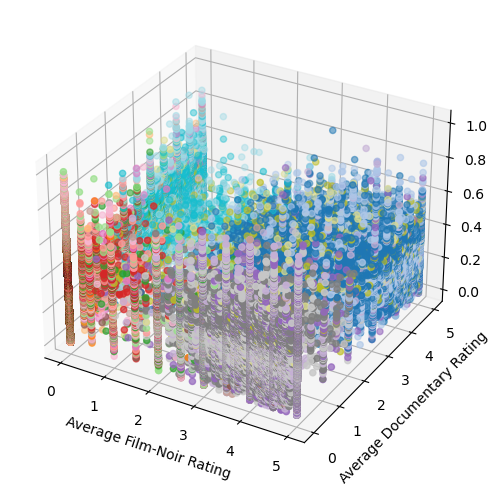

In [250]:
#One final testing plot to view our main clusters
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = average_ratings["Film-Noir"]
y = average_ratings["Documentary"]
z = ratings_counts["Action"]
categories = average_ratings["clusters"]

# Create a 3D plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, c=categories, cmap = 'tab20', marker='o')

# Set axis labels
ax.set_xlabel('Average Film-Noir Rating')
ax.set_ylabel('Average Documentary Rating')
ax.set_zlabel('')
print("z-axis: Percentage of Ratings which are for Action Movies")

In [251]:
#Export the model for use in Flask
joblib.dump(model_counts, 'Models/counts_model.pkl')
joblib.dump(model_weighted, "Models/weights_model.pkl")

['Models/weights_model.pkl']